In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Load Retail Dataset
file_path = "OnlineRetail.xlsx"
df = pd.read_excel(file_path, sheet_name='OnlineRetail', engine='openpyxl')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Data Description
print("Dataset Overview:")
print(df.info())
print("Missing Values:")
print(df.isnull().sum())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
# Data Cleaning
df["CustomerID"] = df["CustomerID"].fillna(df["CustomerID"].mean())
df["Description"] = df["Description"].fillna("Unknown")
df["Quantity"] = pd.to_numeric(df["Quantity"], errors='coerce').fillna(0)
df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors='coerce').fillna(0)

# Convert InvoiceDate to datetime and set it as index
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors='coerce')
df.set_index("InvoiceDate", inplace=True)

# Extract Month column for analysis
df["Month"] = df.index.to_period("M").astype(str)

print("Dataset shape after cleaning:", df.shape)

Dataset shape after cleaning: (541909, 8)


In [6]:
# Data Description
print("Dataset Overview:")
print(df.info())
print("Missing Values:")
print(df.isnull().sum())
df.head()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541909 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   UnitPrice    541909 non-null  float64
 5   CustomerID   541909 non-null  float64
 6   Country      541909 non-null  object 
 7   Month        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 37.2+ MB
None
Missing Values:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
Month          0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Month
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12


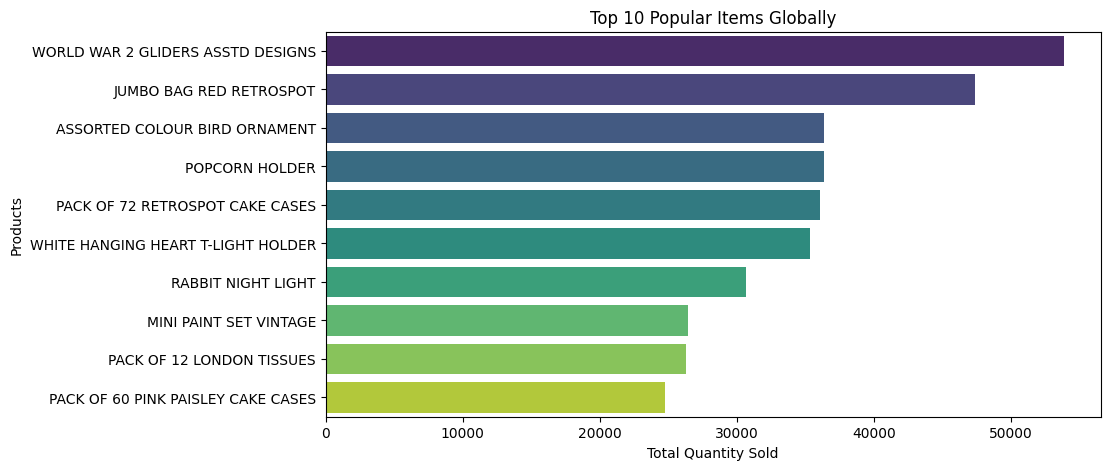

In [7]:
# Find Popular Items using Pivot Table and Seaborn
popular_items = df.pivot_table(index="Description", values="Quantity", aggfunc="sum").sort_values(by="Quantity", ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=popular_items["Quantity"], y=popular_items.index, hue=popular_items.index, palette='viridis', dodge=False)
plt.title("Top 10 Popular Items Globally")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Products")
plt.show()

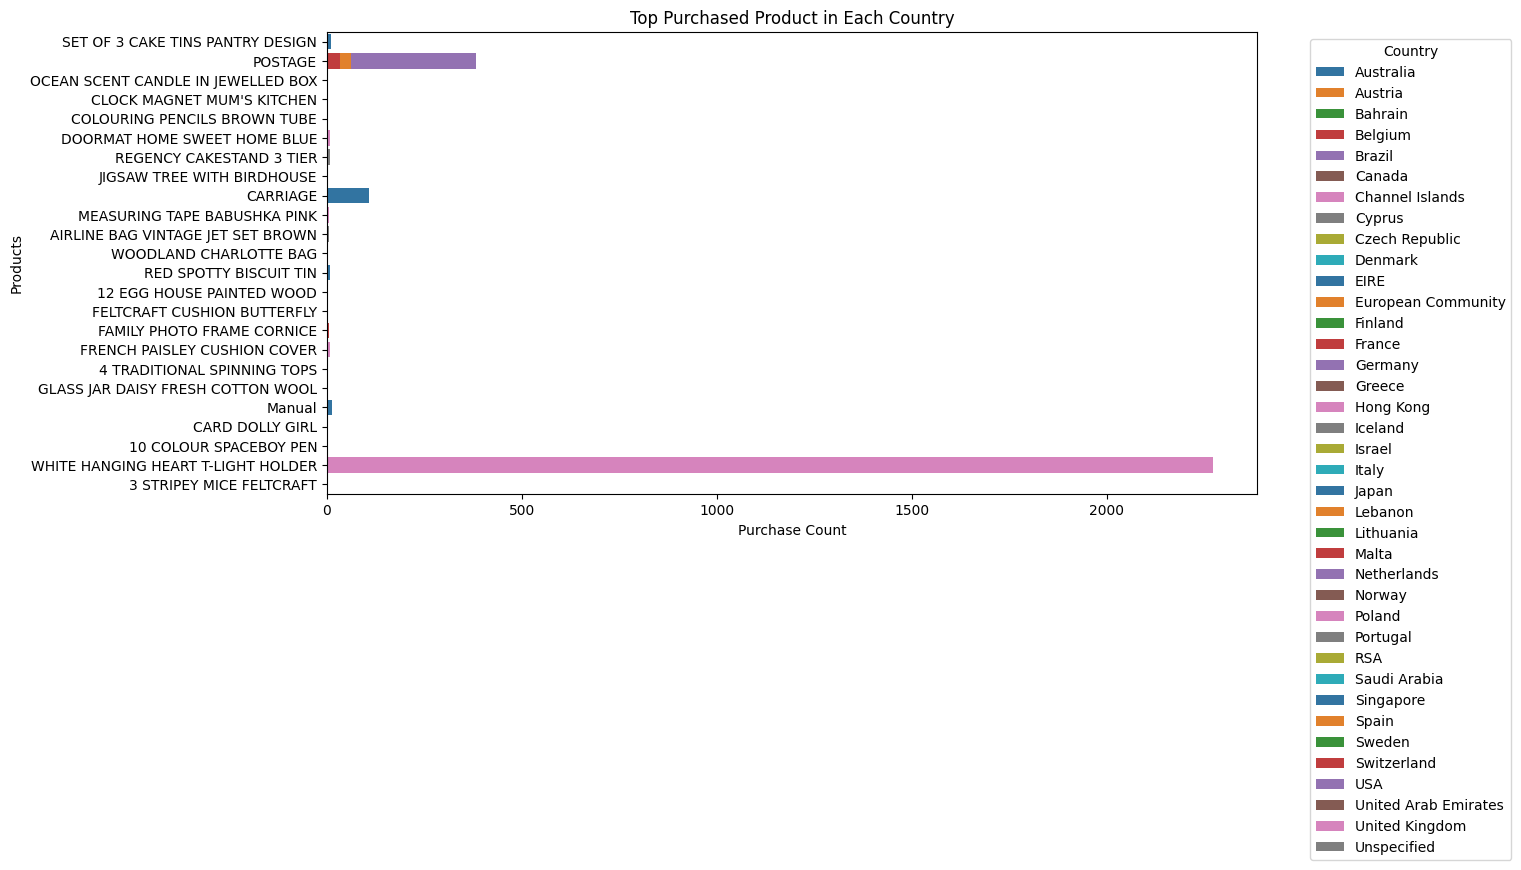

In [8]:
# Find Popular Items - Country-wise
top_products_by_country = df.groupby("Country")["Description"].value_counts().groupby(level=0).head(1).reset_index(name="Count")
plt.figure(figsize=(12,6))
sns.barplot(x="Count", y="Description", hue="Country", data=top_products_by_country, dodge=False, palette='tab10')
plt.title("Top Purchased Product in Each Country")
plt.xlabel("Purchase Count")
plt.ylabel("Products")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

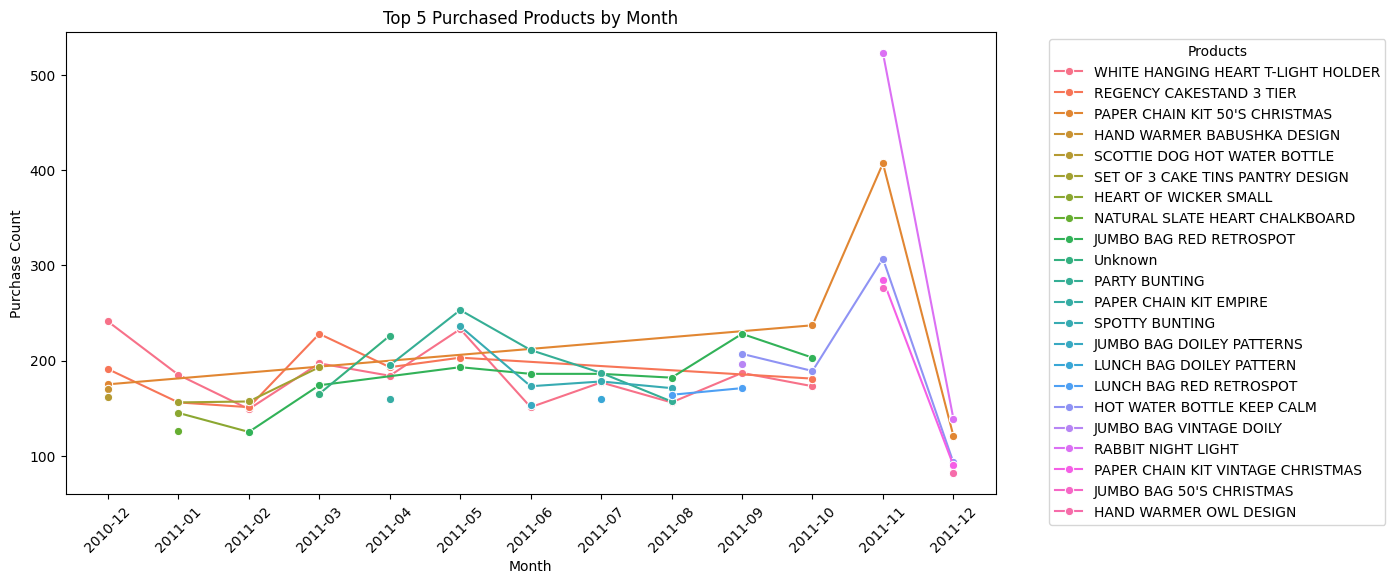

In [9]:
# Find Popular Items - Month-wise
top_products_by_month = df.groupby("Month")["Description"].value_counts().groupby(level=0).head(5).reset_index(name="Count")
plt.figure(figsize=(12,6))
sns.lineplot(x="Month", y="Count", hue="Description", data=top_products_by_month, marker="o")
plt.title("Top 5 Purchased Products by Month")
plt.xlabel("Month")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45)
plt.legend(title="Products", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [10]:
# Function to Analyze & Print Recommendations
pivot_table = df.pivot_table(index="CustomerID", columns="Description", values="Quantity", fill_value=0)
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(pivot_table.T)

NearestNeighbors(algorithm='brute', metric='cosine')

Enter a product name:  light holder


Product 'LIGHT HOLDER' not found. Showing recommendations for 'STAR  T-LIGHT HOLDER' instead.
Predicted Recommendations for: STAR  T-LIGHT HOLDER
Predicted Recommendations for: STAR  T-LIGHT HOLDER
GARLAND, MAGIC GARDEN 1.8M: Similarity Score = 0.69
DOORKNOB CERAMIC IVORY: Similarity Score = 0.69
LARGE BLACK DIAMANTE HAIRSLIDE: Similarity Score = 0.69
3 TRADITIONAL COOKIE CUTTERS  SET: Similarity Score = 0.69
HEN HOUSE W FAMILY IN BARN & NEST: Similarity Score = 0.68


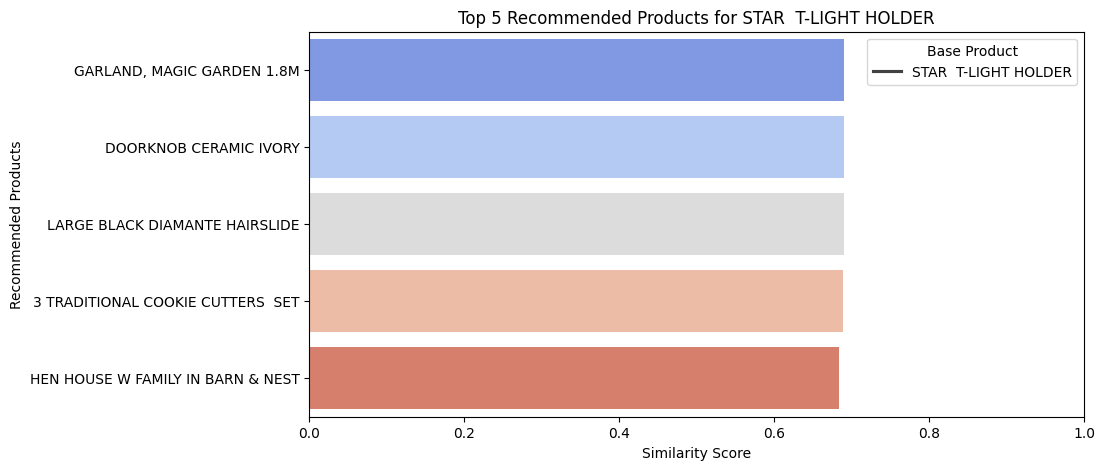

['GARLAND, MAGIC GARDEN 1.8M', 'DOORKNOB CERAMIC IVORY', 'LARGE BLACK DIAMANTE HAIRSLIDE', '3 TRADITIONAL COOKIE CUTTERS  SET', 'HEN HOUSE W FAMILY IN BARN & NEST']


In [13]:
from difflib import get_close_matches

def find_closest_product(user_input, product_list):
    product_list = [str(product) for product in product_list]  # Convert all product names to strings
    matches = get_close_matches(user_input, product_list, n=1, cutoff=0.6)
    return matches[0] if matches else None

def get_predicted_recommendations_with_plot(product_name, top_n=5):
    if product_name not in pivot_table.columns:
        return "Product not found in dataset"
    product_idx = list(pivot_table.columns).index(product_name)
    distances, indices = model.kneighbors([pivot_table.T.iloc[product_idx]], n_neighbors=top_n+1)
    recommended_products = [pivot_table.columns[i] for i in indices.flatten()[1:]]
    similarity_scores = [1 - distances.flatten()[i] for i in range(1, len(distances.flatten()))]  # Convert distance to similarity
    # Print recommendations
    product_description = df[df['Description'] == product_name]['Description'].values[0] if product_name in df['Description'].values else product_name
    print(f"Predicted Recommendations for: {product_description}")
    for prod, score in zip(recommended_products, similarity_scores):
        print(f"{prod}: Similarity Score = {score:.2f}")
    
    # Plot recommendations
    plt.figure(figsize=(10, 5))
    sns.barplot(y=recommended_products, x=similarity_scores, hue=recommended_products, palette='coolwarm', legend=False)
    plt.xlabel("Similarity Score")
    plt.ylabel("Recommended Products")
    plt.title(f"Top {top_n} Recommended Products for {product_description}")
    plt.legend([product_name], title="Base Product", loc='upper right')
    plt.xlim(0, 1)  # Similarity score range
    plt.show()
    
    return recommended_products

user_product = input("Enter a product name: ").strip().upper()

if user_product not in pivot_table.columns:
    closest_match = find_closest_product(user_product, pivot_table.columns)
    if closest_match:
        print(f"Product '{user_product}' not found. Showing recommendations for '{closest_match}' instead.")
        user_product = closest_match
    else:
        print("Error: No similar products found. Please enter a valid product name.")
        exit()  # Choosing the first product as an example
if user_product in pivot_table.columns:
    print(f"Predicted Recommendations for: {user_product}")
    print(get_predicted_recommendations_with_plot(user_product))
else:
    print("Error: Product not found in the dataset. Please enter a valid product name.")